# Přísnost známkování na TIMSS datech

Trends in International Mathematics and Science Study: https://en.wikipedia.org/wiki/Trends_in_International_Mathematics_and_Science_Study

Cílem je prozkoumat rozdíly v přísnosti známkování mezi školami na základě jejich různých charakteristik -- například kraj, velikost sídla apod. TIMSS data obsahují testové skóry a známky pro matematiku a přírodovědu (science), navíc lze dataset napojit s doplňujícími informacemi o škole.

Testové skóry jsou v datasetu s pěti plausible values - žáci zpravidla vyplňují pouze část z celé testové baterie, plausible values jsou nutné pro správné odhady směrodatných chyb. Metodologie týkající se plausible values v TIMSS a dalších mezinárodních vzdělávacích studiích je někde určitě popsaná důkladněji. Pro bodové odhady stačí vzít průměry plausible values. Pro odhadovaný model by možná bylo žádoucí pracovat s plausible values lepším způsobem, nejsem si jistý. Pravděpodobně by to ale neovlivnilo směr závěrů.

Odhady pro školy jsou založené na fixed effects modelu, který je v ekonometrii poměrně častý - zjednodušeně se dá přirovnat k lineárnímu modelu s odlišnými intercepts pro jednotlivé školy (nebo třídy). Nejsem si stoprocentně jistý, zdali je tento postup ideální pro analýzu rozdílů v přísnosti známkování, ale zatím jsem nevymyslel nic lepšího.

## Shrnutí

- Mezi skupinami jsou rozdíly, které jsou relativně stabilní pro danou školu nebo třídu (tzn. vysoká korelace efektů v matematice a přírodovědě - nemůže to ale být dáno tím, že někdy se bere stejná známka nebo stejný testovací skór pro oba předměty? Snad ne, v popisu dat jsem na nic podobného nenarazil - navíc stejná známka by mohla mít leckdy opačný efekt.)
- Rozdíly se nedaří vysvětlit dostupnými charakteristikami škol - velikost obce, lokalita, životní úroveň
- Je těžké posoudit význam velikosti efektů - většina škol se nachází zhruba +/- třetinu známkového stupně od průměrného hodnocení. Tedy mezi školami jsou rozdíly až do přibližně dvou třetin známkového stupně, což není zanedbatelný rozdíl.

## Co bych ještě chtěl dořešit?

- [ ] Plausible values: pro bodové odhady je jejich průměr v pohodě, jak je to ale s dalšími regresními odhady? Neměl bych v takovém případě uvažovat i variabilitu ztracenou zahozením plausible values? Byla by to další nahodilost v prediktorech v FE modelu?
  - Možná to vede k mírně odlišným výsledkům, ale asi to nemá zásadní vliv na hlavní zjištění - že rozdíly v přísnosti nejsou příliš velké a nelze je snadno vysvětlit školními charakteristikami.
  - Chci kromě FE modelu doplnit o nějaké deskriptivní grafy?
  - Nebylo by korektní zpracování PV prostě jen rozdělení každého studenta na 5 plausible studentů?
- [ ] Je FE model zde vhodný? Nebylo by lepší použít nějaký víceúrovňový?

## Příprava dat

In [1]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
#import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
#plt.ioff()

In [2]:
# cesta k datum
data_root = '/mnt/d/projects/idea/data'

In [3]:
# načtení dat - obecně data k mezinárodním vzdělávacím studiím jsou ve formátu .sav pro SPSS
# v SPSS existuje i plugin pro korektní práci s plausible values, nicméně pro naše účely není potřeba
# - pro bodové odhady by mělo stačit zprůměrování plausible values; navíc nemám SPSS...
sg11, sg11_meta = pyreadstat.read_sav(f'{data_root}/TIMSS/2011/CZ/T11_dot_zak.sav')
sg15, sg15_meta = pyreadstat.read_sav(f'{data_root}/TIMSS/2015/CZ/ASGCZEM6.sav')

In [4]:
# takto vypadjí raw data
sg11

,IDCNTRY,IDBOOK,IDSCHOOL,IDCLASS,IDSTUD,IDGRADE,ITBIRTHD,ITBIRTHM,ITBIRTHY,ITSEX,...,o07b,o07c,o07d,o08a,o08b,o08c,o08d,o08e,o08f,o13
0,203.0,8.0,1.0,102.0,10201.0,4.0,23.0,10.0,2000.0,2.0,...,1.0,1.0,2.0,4.0,4.0,3.0,2.0,1.0,3.0,4.0
1,203.0,9.0,1.0,102.0,10202.0,4.0,4.0,5.0,2001.0,2.0,...,2.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,2.0,4.0
2,203.0,10.0,1.0,102.0,10203.0,4.0,14.0,12.0,1999.0,2.0,...,1.0,2.0,2.0,4.0,3.0,1.0,1.0,3.0,1.0,4.0
3,203.0,11.0,1.0,102.0,10204.0,4.0,13.0,2.0,2001.0,2.0,...,2.0,2.0,2.0,3.0,3.0,4.0,2.0,1.0,2.0,2.0
4,203.0,12.0,1.0,102.0,10205.0,4.0,19.0,7.0,2001.0,2.0,...,2.0,2.0,2.0,4.0,3.0,3.0,4.0,1.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4573,203.0,2.0,2167.0,216702.0,21670221.0,4.0,28.0,7.0,2001.0,2.0,...,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,4.0,3.0
4574,203.0,3.0,2167.0,216702.0,21670222.0,4.0,10.0,9.0,2000.0,1.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,4.0
4575,203.0,4.0,2167.0,216702.0,21670223.0,4.0,6.0,9.0,2001.0,1.0,...,1.0,1.0,2.0,3.0,3.0,2.0,2.0,1.0,4.0,3.0
4576,203.0,5.0,2167.0,216702.0,21670224.0,4.0,18.0,10.0,2000.0,2.0,...,2.0,2.0,2.0,2.0,3.0,3.0,2.0,1.0,3.0,4.0


In [5]:
# vyber jen užitečné proměnné, vynech nesmyslné známky, napočítej průměry přes plausible values pro mat a sci

shared_cols = {
    'IDSCHOOL': 'school',
    'IDCLASS': 'class',
    'IDSTUD': 'student',
    'ITSEX': 'girl',
    'TOTWGT': 'weight',
    **{f'ASMMAT0{i}': f'mat_pv{i}' for i in range(1, 6)},
    **{f'ASSSCI0{i}': f'sci_pv{i}' for i in range(1, 6)}
}

cols11 = {**shared_cols, 'o02c': 'mat_grade', 'o02d': 'sci_grade' }
cols15 = {**shared_cols, 'ASXG20C': 'mat_grade', 'ASXG20D': 'sci_grade' }

sg11 = sg11[cols11.keys()].rename(columns=cols11)
sg15 = sg15[cols15.keys()].rename(columns=cols15)

for c in ['school', 'class', 'student', 'girl']:
    sg11[c] = pd.Series(sg11[c], dtype=np.int_)
    sg15[c] = pd.Series(sg15[c], dtype=np.int_)

sg11['girl'] = -sg11['girl'] + 2
sg15['girl'] = -sg15['girl'] + 2

for c in ['mat', 'sci']:
    sg11[c + '_grade'] = np.where(sg11[c + '_grade'] > 5, np.nan, sg11[c + '_grade'])
    sg15[c + '_grade'] = np.where(sg15[c + '_grade'] > 5, np.nan, sg15[c + '_grade'])
    sg11[c] = np.mean(sg11[[f'{c}_pv{i}' for i in range(1, 6)]], axis=1)
    sg15[c] = np.mean(sg15[[f'{c}_pv{i}' for i in range(1, 6)]], axis=1)
    sg11 = sg11.drop(columns=[f'{c}_pv{i}' for i in range(1, 6)])
    sg15 = sg15.drop(columns=[f'{c}_pv{i}' for i in range(1, 6)])

sg11['unit'] = 1
sg15['unit'] = 1

In [6]:
# z dat vyberu jen co potřebuji a plausible values nahrazuji průměrem
sg11

,school,class,student,girl,weight,mat_grade,sci_grade,mat,sci,unit
0,1,102,10201,0,13.344744,1.0,1.0,614.667474,646.389064,1
1,1,102,10202,0,13.344744,1.0,1.0,585.620028,658.707538,1
2,1,102,10203,0,13.344744,3.0,2.0,474.949460,458.692266,1
3,1,102,10204,0,13.344744,1.0,1.0,520.417550,507.918698,1
4,1,102,10205,0,13.344744,3.0,1.0,489.474880,557.399712,1
...,...,...,...,...,...,...,...,...,...,...
4573,2167,216702,21670221,0,4.385031,1.0,1.0,531.534766,541.234242,1
4574,2167,216702,21670222,1,4.385031,1.0,1.0,644.117658,628.935314,1
4575,2167,216702,21670223,1,4.385031,1.0,1.0,562.279782,564.929678,1
4576,2167,216702,21670224,0,4.385031,2.0,3.0,502.262130,540.098306,1


In [7]:
cg15, cg15_meta = pyreadstat.read_sav(f'{data_root}/TIMSS/2015/CZ/ACGCZEM6.sav')
cg11, cg11_meta = pyreadstat.read_sav(f'{data_root}/TIMSS/2011/CZ/T11_dot_skolni.sav')

cg15['school'] = np.int_(cg15['IDSCHOOL'])
cg11['school'] = np.int_(cg11['IDSCHOOL'])

In [8]:
cg11

,IDCNTRY,IDSCHOOL,ACBG01,ACBG02,ACBG03A,ACBG03B,ACBG04,ACBG05A,ACBG05B,ACBG05C,...,ACDGEAS,ACBGDAS,ACDGDAS,ACDG03,ACDGENS,ACDG09,ACDGCMP,ACDG06HY,ACDG06,school
0,203.0,1.0,693.0,74.0,2.0,2.0,1.0,1.0,2.0,2.0,...,3.0,9.45643,2.0,2.0,4.0,1.0,1.0,727.50,5.0,1
1,203.0,2.0,613.0,66.0,3.0,3.0,1.0,1.0,2.0,1.0,...,2.0,9.14425,2.0,2.0,1.0,1.0,2.0,NaN,5.0,2
2,203.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3
3,203.0,4.0,339.0,33.0,2.0,1.0,2.0,1.0,1.0,3.0,...,3.0,10.17820,1.0,2.0,4.0,2.0,1.0,731.25,5.0,4
4,203.0,5.0,463.0,60.0,2.0,2.0,1.0,1.0,2.0,2.0,...,3.0,8.86115,2.0,2.0,4.0,2.0,2.0,837.25,5.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,203.0,2012.0,81.0,8.0,NaN,NaN,1.0,6.0,5.0,3.0,...,2.0,9.45643,2.0,NaN,4.0,2.0,1.0,843.75,5.0,2012
173,203.0,2100.0,37.0,8.0,4.0,2.0,1.0,6.0,5.0,2.0,...,2.0,11.81833,1.0,3.0,3.0,3.0,1.0,776.25,5.0,2100
174,203.0,2119.0,364.0,37.0,1.0,3.0,1.0,5.0,4.0,2.0,...,2.0,9.45643,2.0,1.0,4.0,4.0,1.0,806.25,5.0,2119
175,203.0,2154.0,110.0,26.0,4.0,1.0,2.0,4.0,4.0,3.0,...,3.0,11.81833,1.0,3.0,4.0,4.0,1.0,712.50,5.0,2154


In [9]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Fixed effects model

> Výběr modelu je trochu intuitivní -- bylo by lepší použít nějaký jiný přístup? Co nějaké multilevel modely (kterým ale nerozumím)? Stejně tak i k matematice a předpokladům přistupuju trochu pocitově.

Fixed effects model je v zásadě rychlejší metoda odhadu skupinových konstantních členů.

Předpokládejme následující model, kde pozorování jsou sdružena do skupin:

\begin{equation}\label{eqref:fe}
    y_{ij} = \alpha + \beta x_{ij} + \mu_i + \varepsilon_{ij}
\end{equation}

Kde $j = 1 \dots J_i$ jsou indexy v rámci skupin, $i = 1 \dots I$ jsou indexy skupin. $\mu_i$ je noise term pro jednotlivé skupiny (na který lze také nahlížet jako na odlišný intercept v rámci skupin; po celou dobu však předpokládáme shodný koeficient $\beta$ ve všech skupinách), $\varepsilon_{ij}$ noise term pro pozorování s obvyklými předpoklady (nezávislost, nestrannost). Použití běžné regrese vede k nekonzistentním výsledkům, neboť chyby uvnitř skupin jsou vzájemně korelované kvůli sdílenému $\mu_i$ členu.

Pokud do modelu doplníme indikátorové proměnné pro jednotlivé skupiny, pak získáme správný odhad ($\alpha$ bude dána váženým průměrem těchto skupinových koeficientů). Při velkém počtu skupin však může být takový odhad výpočetně náročný, alternativou je použití fixed effects modelu. Pokud rovnici (\ref{eqref:fe}) zprůměrujeme uvnitř skupin a následně i celkově:

\begin{eqnarray}
    y_{i\bullet} = \alpha + \beta x_{i\bullet} + \mu_i + \varepsilon_{i\bullet} \label{eqref:groupmeanfe}\\
    y_{\bullet\bullet} = \alpha + \beta x_{\bullet\bullet} + \mu_{\bullet} + \varepsilon_{\bullet\bullet} \label{eqref:grandmeanfe}
\end{eqnarray}

Kde $y_{i\bullet} = \frac{1}{J_i} \sum_{j = 1}^{J_i} y_{ij}$ a $y_{\bullet\bullet} = \frac{1}{N} \sum_{i = 1}^{I} \sum_{j = 1}^{J_i} y_{ij}$, analogicky pro $x_{i\bullet}$ a $x_{\bullet\bullet}$. Z předpokladů regrese dále vyplývá $\mu_{\bullet} = \varepsilon_{\bullet\bullet} = \varepsilon_{i\bullet} = 0$. Zkombinováním rovnic (\ref{eqref:fe}) - (\ref{eqref:groupmeanfe}) + (\ref{eqref:grandmeanfe}) dostáváme:

\begin{equation} \label{eqref:fullfe}
    (y_{ij} - y_{i\bullet} + y_{\bullet\bullet}) = \alpha + \beta \cdot (x_{ij} - x_{i\bullet} + x_{\bullet\bullet}) + \varepsilon_{ij}
\end{equation}

Z rovnice (\ref{eqref:fullfe}) můžeme obyčejnou regresí odhadnout koeficienty $\alpha$ a $\beta$, následně z rovnice (\ref{eqref:groupmeanfe}) můžeme dopočítat skupinové parametry $\mu_i$. Model lze snadno zobecnit na více prediktorů.



Skupinové parametry $\mu_i$ odpovídají rozdílům v přísnosti známkování v jednotlivých školách (nebo případně třídách). Tyto parametry pak můžeme porovnat s dalšími informacemi o školách, například s krajem, velikostí obce apod.

In [10]:
def get_weighted_means(frame, weight_col='weight', cols=None):
    """
    Calculates weighted means of dataframe columns.
    
    :param frame: Input dataframe.
    :param weight_col: Column containing weights.
    :param cols: Columns to calculate the weighted means of. If not provided, use all non-weight columns.
    :return: Series with weighted means, keyed by column names.
    """
    res = pd.Series(dtype='float64')
    for c in cols or frame.columns[frame.columns != weight_col]:
        res[c] = (frame[c] * frame[weight_col]).sum() / frame[weight_col].sum()
    return res

def get_fixed_effects(df, group_col, grade_col, score_col, girl_col='girl', weight_col='weight'):
    df = df[[group_col, grade_col, score_col, girl_col, weight_col]].dropna().copy()
    
    # pomocí DescrStatsW získáme vážené průměry i směrodatné odchylky
    stats_grade = DescrStatsW(df[grade_col], weights=df[weight_col])
    stats_score = DescrStatsW(df[score_col], weights=df[weight_col])

    # převod na z-skóry, aby následně parametry bylo možné interpretovat ve směrodatných odchylkách
    # chci z-skóry i u známek? - asi ne, známky jsou zde snadněji interpretovatelné
    df[score_col] = (df[score_col] - stats_score.mean) / stats_score.std
    # df[grade_col] = -(df[grade_col] - stats_grade.mean) / stats_grade.std

    cols = [grade_col, score_col, girl_col]
    
    # c_means dataframe obsahuje skupinové průměry
    c_means = df.groupby(group_col).apply(get_weighted_means, weight_col=weight_col, cols=cols).reset_index()
    df = pd.merge(df, c_means.rename(columns={c: c + '_cm' for c in cols}))
    for c in cols:
        # _adj sloupce jsou proměnné pro odhad rovnice (4)
        df[c + '_adj'] = df[c] - df[c + '_cm'] + np.average(df[c], weights=df[weight_col])

    # WLS ze statsmodels je Weighted Least Squares
    model = sm.WLS(df[grade_col + '_adj'], sm.add_constant(df[[score_col + '_adj', girl_col + '_adj']]), weights=df[weight_col]).fit()

    # zpětným dosazením napočítáme \mu_i (označené jako fe pro fixed effects)
    c_means['fe'] = c_means[grade_col] - model.params['const'] \
        - model.params[score_col + '_adj'] * c_means[score_col] \
        - model.params[girl_col + '_adj'] * c_means[girl_col]
    c_means['count'] = df.groupby(group_col)[grade_col].count().values

    # a vrátíme dataframe s indexem skupiny, fixed effects a počtem žáků ve skupinách
    return c_means[[group_col, 'fe', 'count']]

## Základní popisné statistiky

In [11]:
sg11

,school,class,student,girl,weight,mat_grade,sci_grade,mat,sci,unit
0,1,102,10201,0,13.344744,1.0,1.0,614.667474,646.389064,1
1,1,102,10202,0,13.344744,1.0,1.0,585.620028,658.707538,1
2,1,102,10203,0,13.344744,3.0,2.0,474.949460,458.692266,1
3,1,102,10204,0,13.344744,1.0,1.0,520.417550,507.918698,1
4,1,102,10205,0,13.344744,3.0,1.0,489.474880,557.399712,1
...,...,...,...,...,...,...,...,...,...,...
4573,2167,216702,21670221,0,4.385031,1.0,1.0,531.534766,541.234242,1
4574,2167,216702,21670222,1,4.385031,1.0,1.0,644.117658,628.935314,1
4575,2167,216702,21670223,1,4.385031,1.0,1.0,562.279782,564.929678,1
4576,2167,216702,21670224,0,4.385031,2.0,3.0,502.262130,540.098306,1


Text(0.5, 1.0, 'TIMSS 2015, sci_grade')

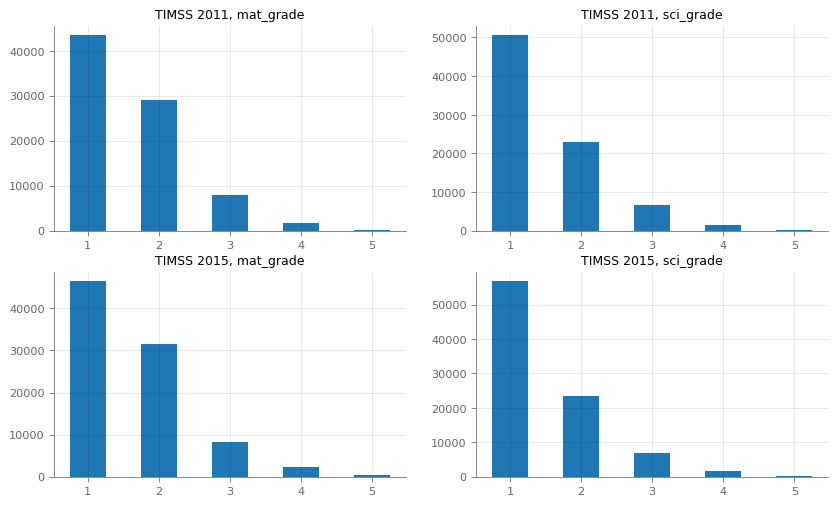

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
#sns.histplot(data=sg11, x='mat_grade', ax=axes[0][0])
bins = np.arange(6) + 0.5
axes[0][0].hist(sg11['mat_grade'], rwidth=0.5, weights=sg11['weight'], bins=bins)
axes[0][0].set_title('TIMSS 2011, mat_grade', fontsize=10)
axes[0][1].hist(sg11['sci_grade'], rwidth=0.5, weights=sg11['weight'], bins=bins)
axes[0][1].set_title('TIMSS 2011, sci_grade', fontsize=10)
axes[1][0].hist(sg15['mat_grade'], rwidth=0.5, weights=sg15['weight'], bins=bins)
axes[1][0].set_title('TIMSS 2015, mat_grade', fontsize=10)
axes[1][1].hist(sg15['sci_grade'], rwidth=0.5, weights=sg15['weight'], bins=bins)
axes[1][1].set_title('TIMSS 2015, sci_grade', fontsize=10)

Text(0.5, 1.0, 'TIMSS 2015, sci score')

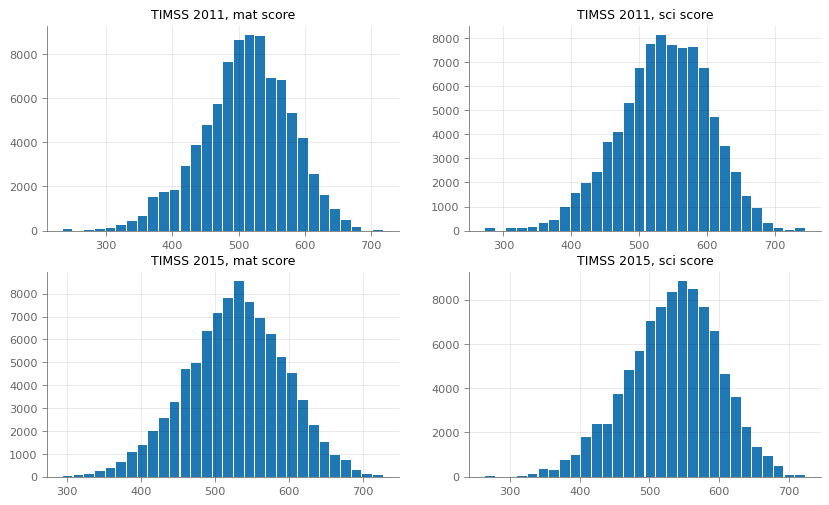

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0][0].hist(sg11['mat'], bins=30, rwidth=0.9, weights=sg11['weight'])
axes[0][0].set_title('TIMSS 2011, mat score', fontsize=10)
axes[0][1].hist(sg11['sci'], bins=30, rwidth=0.9, weights=sg11['weight'])
axes[0][1].set_title('TIMSS 2011, sci score', fontsize=10)
axes[1][0].hist(sg15['mat'], bins=30, rwidth=0.9, weights=sg15['weight'])
axes[1][0].set_title('TIMSS 2015, mat score', fontsize=10)
axes[1][1].hist(sg15['sci'], bins=30, rwidth=0.9, weights=sg15['weight'])
axes[1][1].set_title('TIMSS 2015, sci score', fontsize=10)

In [14]:
for yy in ['sg11', 'sg15']:
    for cc in ['mat', 'sci', 'mat_grade', 'sci_grade']:
        df = eval(yy)[[cc, 'weight']].dropna()
        dsw = DescrStatsW(df[cc], weights=df['weight'])
        print(f'{yy}, {cc}: mean={dsw.mean:.4g}, std={dsw.std:.4g}')

sg11, mat: mean=510.8, std=66.65
sg11, sci: mean=536.4, std=66.94
sg11, mat_grade: mean=1.615, std=0.7578
sg11, sci_grade: mean=1.51, std=0.7461
sg15, mat: mean=528.1, std=66.65
sg15, sci: mean=534.4, std=65.17
sg15, mat_grade: mean=1.63, std=0.7836
sg15, sci_grade: mean=1.477, std=0.7256


In [15]:
fe15_mat = get_fixed_effects(sg15, 'school', 'mat_grade', 'mat')
fe15_sci = get_fixed_effects(sg15, 'school', 'sci_grade', 'sci')
fe11_mat = get_fixed_effects(sg11, 'school', 'mat_grade', 'mat')
fe11_sci = get_fixed_effects(sg11, 'school', 'sci_grade', 'sci')

fe15_mat_class = get_fixed_effects(sg15, 'class', 'mat_grade', 'mat')
fe15_sci_class = get_fixed_effects(sg15, 'class', 'sci_grade', 'sci')
fe11_mat_class = get_fixed_effects(sg11, 'class', 'mat_grade', 'mat')
fe11_sci_class = get_fixed_effects(sg11, 'class', 'sci_grade', 'sci')

/mnt/d/projects/idea/code/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Rozložení třídních / školních efektů

Skupinové efekty jsou vyjádřeny v prostoru známek - tzn. školní efekt 0.25 znamená, že žáci s určitým skórem dostávají o 0.25 stupně horší známku než by dostali v průměrné škole (tedy známkování zde je o 0.25 stupně přísnější).

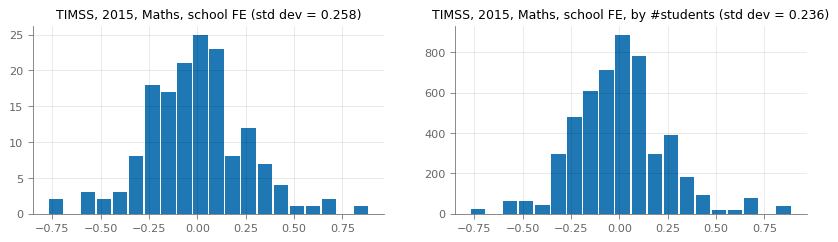

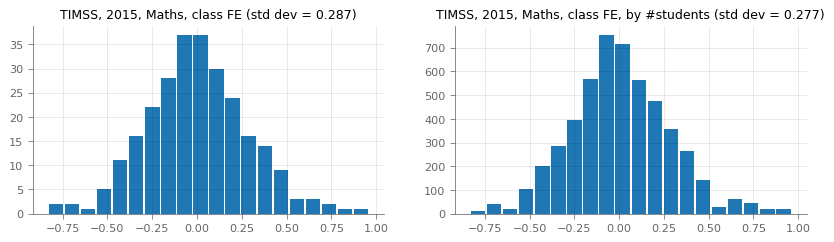

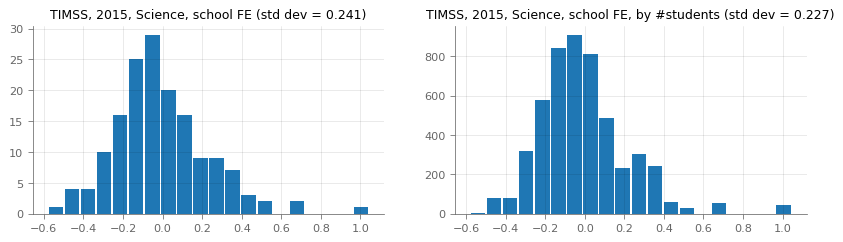

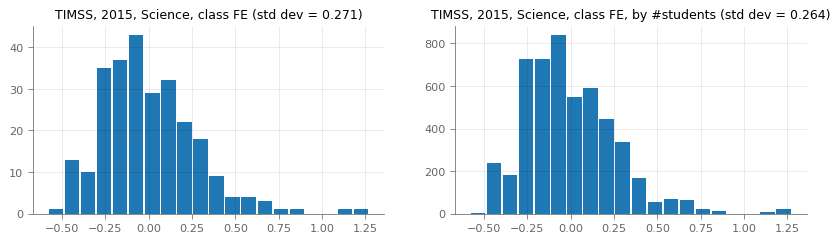

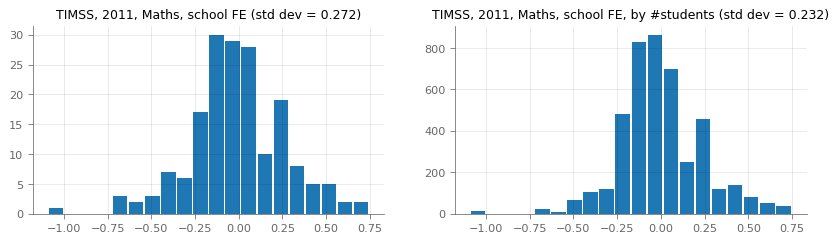

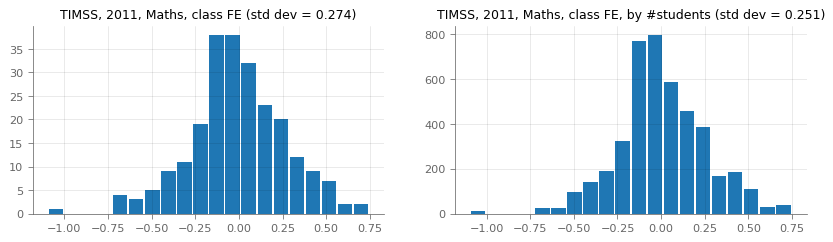

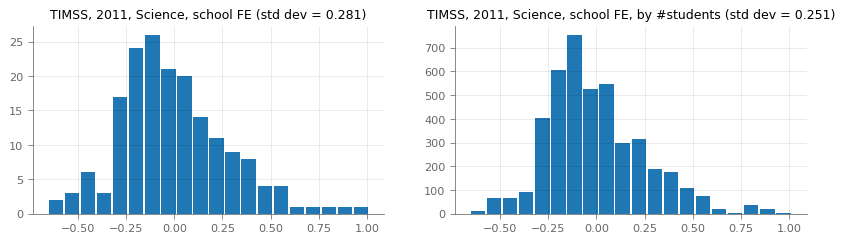

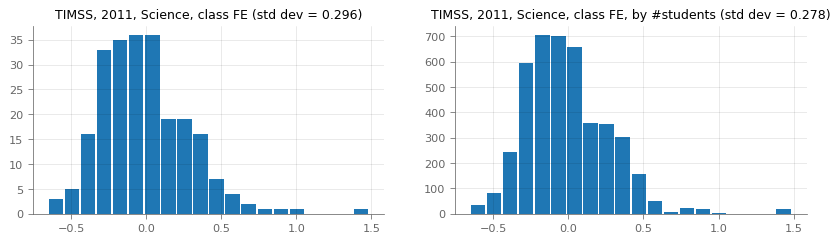

In [18]:
def hist_fe(fe, weights=False, title='', ax=None):
    stat = DescrStatsW(fe['fe'], weights=(fe['count'] if weights else None))
    ax = ax or plt.gca()
    ax.hist(fe['fe'], bins=20, rwidth=0.9, weights=(fe['count'] if weights else None))
    ax.set_title('{} (std dev = {:.3g})'.format(title, stat.std), fontsize=10)
    return ax

plt.rcParams['figure.figsize'] = 10, 2.5

for y in [15, 11]:
    for c in ['mat', 'sci']:
        for g in ['school', 'class']:
            fig, axes = plt.subplots(1, 2)
            for w in [0, 1]:
                fe = eval('fe{}_{}{}'.format(y, c, ('' if g == 'school' else '_class')))
                title = 'TIMSS, 20{}, {}, {} FE{}'.format(y, ('Maths' if c == 'mat' else 'Science'), g,
                    (', by #students' if w else ''))
                hist_fe(fe, w, title, ax=axes[w])                

## Stabilita třídních / školních efektů

Data vykazují poměrně vysokou korelaci mezi skupinovými efekty v matematice a v přírodovědě. Skupiny se tedy pravděpodobně opravdu liší v přísnosti známkování, jen ji nedokážeme dobře vysvětlit pozorovanými atributy.

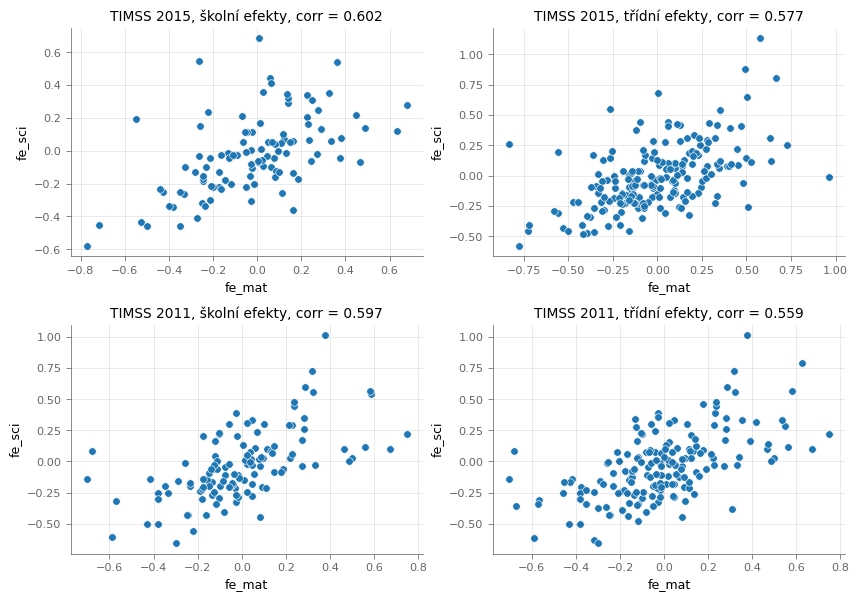

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
plt.subplots_adjust(hspace=0.3)

fe15 = pd.merge(fe15_mat.rename(columns={'fe': 'fe_mat'}), fe15_sci.rename(columns={'fe': 'fe_sci'}))
dsw = DescrStatsW(fe15[['fe_mat', 'fe_sci']], weights=fe15['count'])
sns.scatterplot(data=fe15, x='fe_mat', y='fe_sci', ax=axes[0][0])
axes[0][0].set_title(f'TIMSS 2015, školní efekty, corr = {dsw.corrcoef[0, 1]:.3g}')

fe15_class = pd.merge(fe15_mat_class.rename(columns={'fe': 'fe_mat'}), fe15_sci_class.rename(columns={'fe': 'fe_sci'}))
dsw = DescrStatsW(fe15_class[['fe_mat', 'fe_sci']], weights=fe15_class['count'])
sns.scatterplot(data=fe15_class, x='fe_mat', y='fe_sci', ax=axes[0][1])
axes[0][1].set_title(f'TIMSS 2015, třídní efekty, corr = {dsw.corrcoef[0, 1]:.3g}')

fe11 = pd.merge(fe11_mat.rename(columns={'fe': 'fe_mat'}), fe11_sci.rename(columns={'fe': 'fe_sci'}))
dsw = DescrStatsW(fe11[['fe_mat', 'fe_sci']], weights=fe11['count'])
sns.scatterplot(data=fe11, x='fe_mat', y='fe_sci', ax=axes[1][0])
axes[1][0].set_title(f'TIMSS 2011, školní efekty, corr = {dsw.corrcoef[0, 1]:.3g}')

fe11_class = pd.merge(fe11_mat_class.rename(columns={'fe': 'fe_mat'}), fe11_sci_class.rename(columns={'fe': 'fe_sci'}))
dsw = DescrStatsW(fe11_class[['fe_mat', 'fe_sci']], weights=fe11_class['count'])
sns.scatterplot(data=fe11_class, x='fe_mat', y='fe_sci', ax=axes[1][1])
axes[1][1].set_title(f'TIMSS 2011, třídní efekty, corr = {dsw.corrcoef[0, 1]:.3g}')
None

## Školní efekty v závislosti na sídle / charakteristikách školy

Některé grafy naznačují rozdíly podle charakteristik, avšak nikdy nelze tento efekt pozorovat v obou předmětech a u obou ročníků. Může se tedy jednat spíše o náhodný šum než o skutečný efekt. Některé školy pravděpodobně jsou přísnější, avšak nemusí se jednat o systematické tendence způsobené pozorovanými charakteristikami škol a obce.

In [28]:
def compare_fe(cg, cg_meta, var, col, label, num_labels, left=0.16, title=None, fe_col='fe'):
    labels = [cg_meta.value_labels[label][x] for x in range(1, num_labels + 1)]
    cg[var] = pd.Categorical(cg[col].apply(lambda x: None if not np.isfinite(x)
        else cg_meta.value_labels[label][x]), labels, ordered=True)
    plt.rcParams['figure.figsize'] = 7, 2.5
    plt.rcParams['figure.subplot.left'] = left
    fig, ax = plt.subplots()
    sns.boxplot(y=var, x=fe_col, data=cg)
    if title is not None:
        ax.set_title(title)
    return ax

def compare_fe_all(cg, cg_meta, vars, cols, labels, num_labels, lefts, title):
    plots = []
    for v, c, l, nl, left in zip(vars, cols, labels, num_labels, lefts):
        ax = compare_fe(cg, cg_meta, v, c, l, nl, left=left)
        ax.set_title(title.format(v))
        plots.append(ax)
    return plots

In [29]:
vars = ['population', 'area', 'poor', 'affluent']
cols = ['ACBG05A', 'ACBG05B', 'ACBG03A', 'ACBG03B']
labels = ['labels{}'.format(i) for i in [5, 6, 2, 3]]
num_labels15 = [7, 5, 4, 4]
num_labels11 = [6, 5, 4, 4]
lefts15 = [0.16, 0.33, 0.16, 0.16]
lefts11 = [0.24, 0.16, 0.16, 0.16]

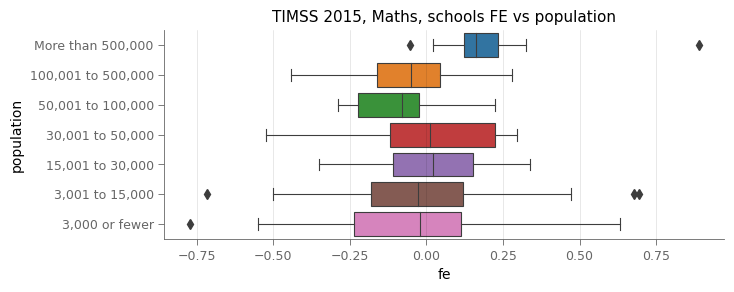

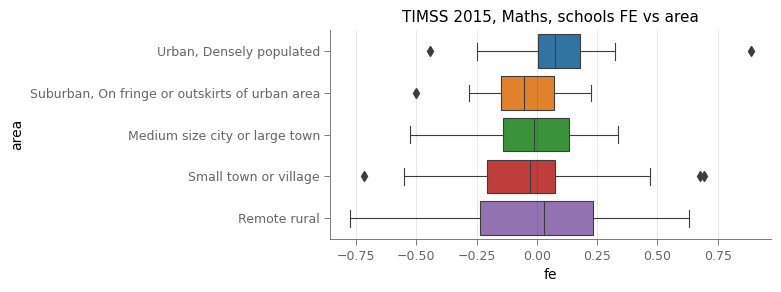

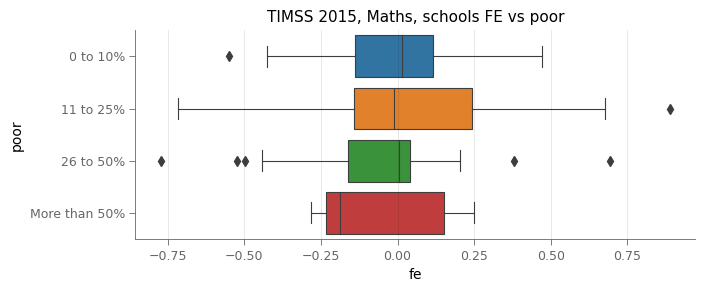

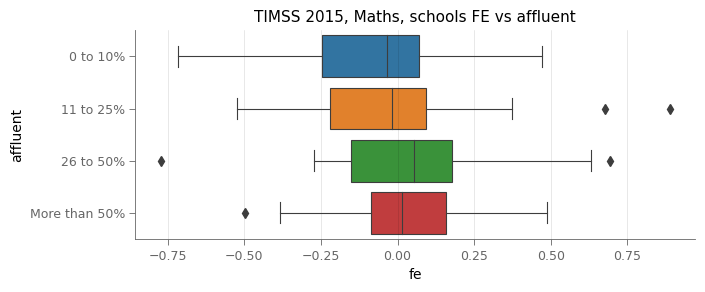

In [30]:
plots15_mat = compare_fe_all(pd.merge(cg15, fe15_mat), cg15_meta, vars, cols, labels, num_labels15, lefts15,
    title='TIMSS 2015, Maths, schools FE vs {}')

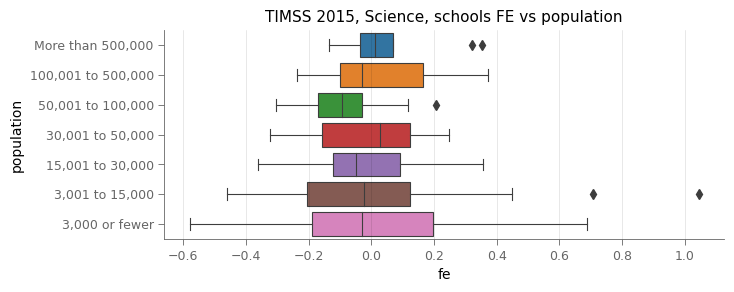

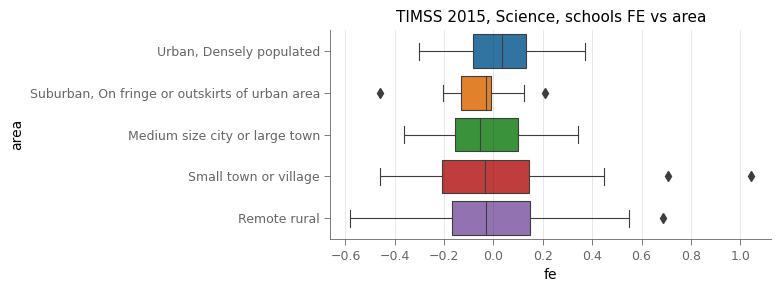

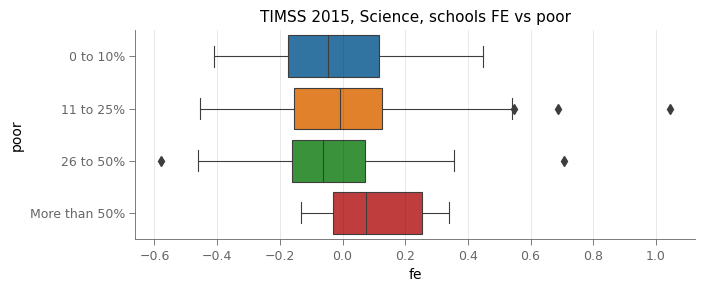

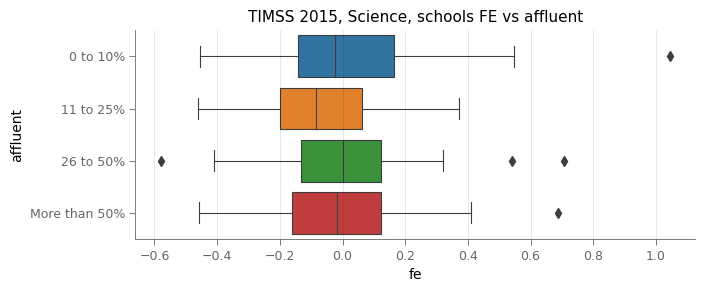

In [31]:
plots15_sci = compare_fe_all(pd.merge(cg15, fe15_sci), cg15_meta, vars, cols, labels, num_labels15, lefts15,
    title='TIMSS 2015, Science, schools FE vs {}')

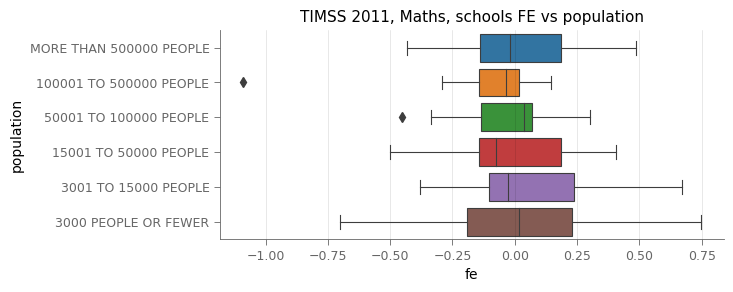

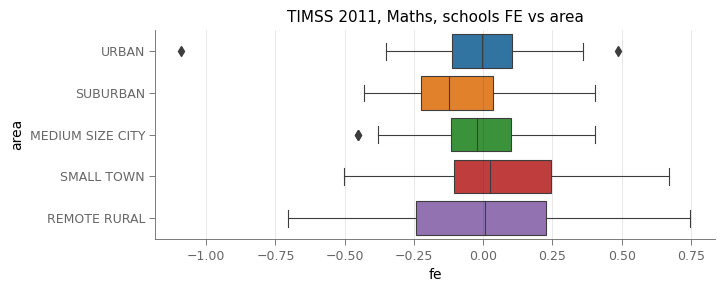

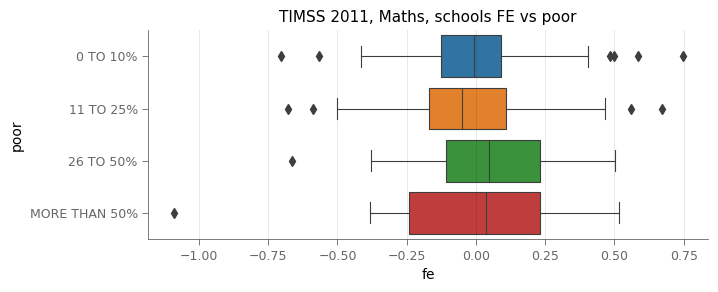

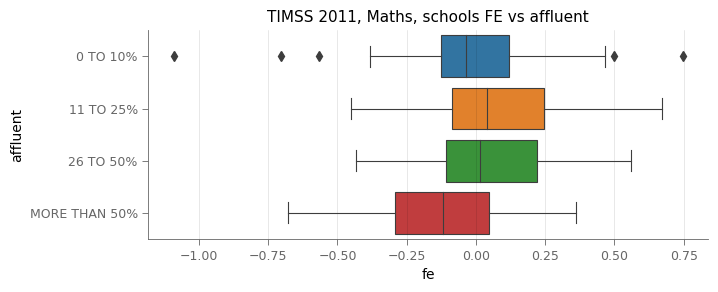

In [32]:
plots11_mat = compare_fe_all(pd.merge(cg11, fe11_mat), cg11_meta, vars, cols, labels, num_labels11, lefts11,
    title='TIMSS 2011, Maths, schools FE vs {}')

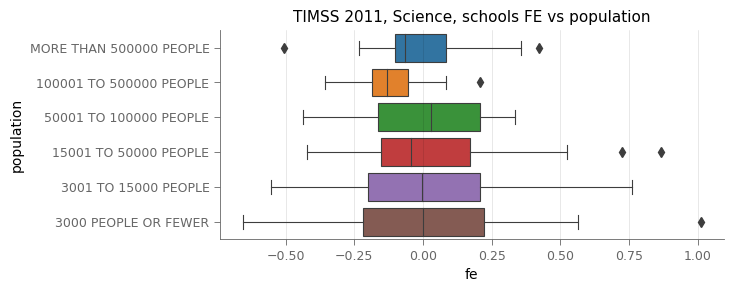

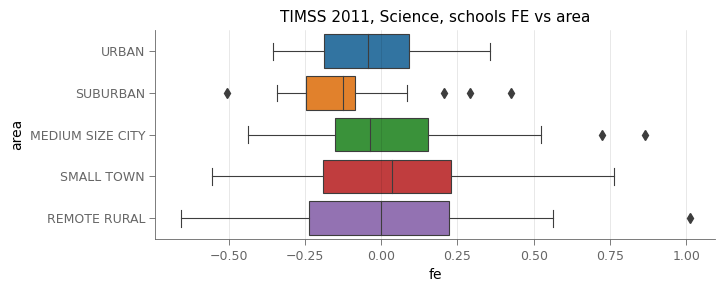

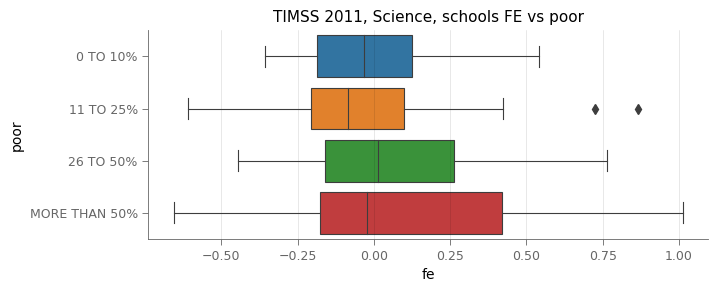

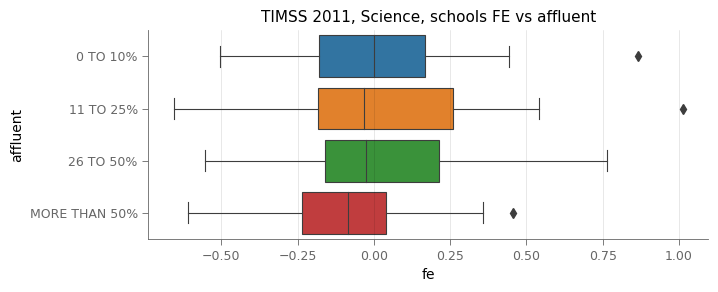

In [33]:
plots11_sci = compare_fe_all(pd.merge(cg11, fe11_sci), cg11_meta, vars, cols, labels, num_labels11, lefts11,
    title='TIMSS 2011, Science, schools FE vs {}')

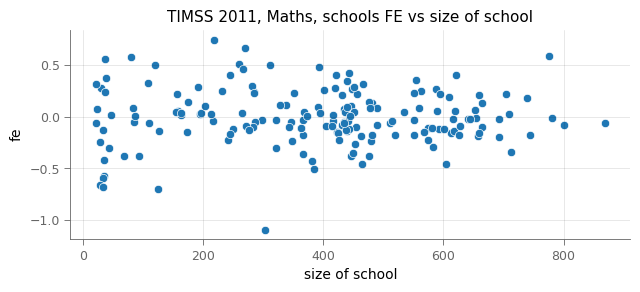

In [34]:
_, size11_mat = plt.subplots()
sns.scatterplot(x='ACBG01', y='fe', data=pd.merge(cg11, fe11_mat))
size11_mat.set(xlabel='size of school')
size11_mat.set_title('TIMSS 2011, Maths, schools FE vs size of school')
None

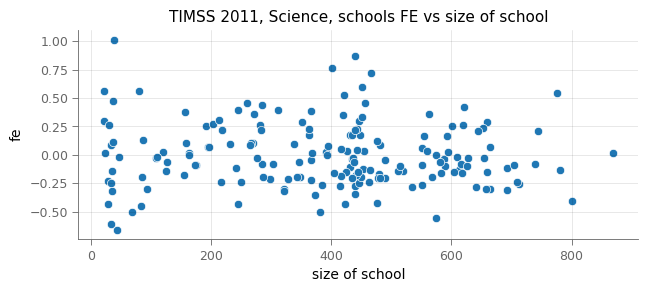

In [35]:
_, size11_sci = plt.subplots()
sns.scatterplot(x='ACBG01', y='fe', data=pd.merge(cg11, fe11_sci))
size11_sci.set(xlabel='size of school')
size11_sci.set_title('TIMSS 2011, Science, schools FE vs size of school')
None